In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '10', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
## IMERG
satellite_path = "/g/data/k10/cb4968/metrics/observations/IMERG/small_domain/pr_based/IMERG/pr_based_IMERG_3hrly_0-360_-30-30_3600x1800_2001-01_2023-12_boxsize_5/"
sat_files = sorted(glob(f"{satellite_path}pr_based_IMERG_3hrly_*.nc"))
ds_sat = xr.open_mfdataset(sat_files,chunks={"time":10})
# ERA5
ds_tcwv = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/tcwv/*.nc")))
ds_max_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/max_cape/*.nc")))
ds_cape = xr.open_mfdataset(sorted(glob("/g/data/k10/cr7888/era5_daily_means_5deg/cape/*.nc")))

## land sea mask
ds_lsm = xr.open_dataset("/g/data/k10/cr7888/era5_daily_means_5deg/lsm_5deg.nc") 

In [4]:
lsm = ds_lsm["lsm"]
# prcp intensity at rain cell
cell_pr = ds_sat["pr_based_mean_pr"]/ds_sat["pr_based_area_fraction"]
# mean precipitation
mean_pr = ds_sat["pr_based_mean_pr"].resample(time='1D').mean().where(lsm == 0)
# Iorg
iorg= ds_sat["pr_based_Iorg"].resample(time='1D').mean().where(lsm == 0)
## make ERA5 data timestamps to match IMERG data
ds_tcwv["time"] = ds_tcwv["time"].dt.floor("D")
ds_max_cape["time"] = ds_max_cape["time"].dt.floor("D")
ds_cape["time"] = ds_cape["time"].dt.floor("D")


In [5]:
%%time
## ERA5 environmental conditions
tcwv = ds_tcwv["tcwv"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
# max CAPE
max_cape = ds_max_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()
cape = ds_cape["cape"].sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).where(lsm == 0).compute()

## IMERG daily
mean_pr_match = mean_pr.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
iorg_match = iorg.sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()
cell_pr_match = cell_pr.resample(time='1D').mean().where(lsm == 0).sel(time=slice(mean_pr["time"][0],ds_tcwv["time"][-1])).compute()                           

CPU times: user 2min 41s, sys: 18 s, total: 2min 59s
Wall time: 2min 32s


In [6]:
def bin_data_with_percentile_subsets(
    x, y, z, percentiles=(20, 80), num_bins=10, bin_min=0.1, bin_max=8.1
):
    '''
    Bin data by x, average y in each bin, and compute 20th/80th percentile split of z.
    Also returns mean x and y for high/low z subsets within each bin, with their counts.
    '''

    # Remove NaNs across all three arrays
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    # Define bins and get bin indices
    bins = np.linspace(bin_min, bin_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_idx = np.digitize(x, bins)

    # Output lists
    bin_counts_all = []
    bin_counts_low = []
    bin_counts_high = []

    mean_y_all = []
    mean_x_all = []

    mean_y_low = []
    mean_x_low = []

    mean_y_high = []
    mean_x_high = []

    for i in range(1, len(bins)):
        idx_bin = bin_idx == i
        if np.any(idx_bin):
            # All data in bin
            x_bin = x[idx_bin]
            y_bin = y[idx_bin]
            z_bin = z[idx_bin]

            # Count all
            bin_counts_all.append(len(x_bin))
            mean_x_all.append(np.nanmean(x_bin))
            mean_y_all.append(np.nanmean(y_bin))

            # Compute 20th and 80th percentile of z
            low_thresh = np.nanpercentile(z_bin, percentiles[0])
            high_thresh = np.nanpercentile(z_bin, percentiles[1])

            # Low subset
            idx_low = z_bin <= low_thresh
            bin_counts_low.append(np.sum(idx_low))
            mean_x_low.append(np.nanmean(x_bin[idx_low]))
            mean_y_low.append(np.nanmean(y_bin[idx_low]))

            # High subset
            idx_high = z_bin >= high_thresh
            bin_counts_high.append(np.sum(idx_high))
            mean_x_high.append(np.nanmean(x_bin[idx_high]))
            mean_y_high.append(np.nanmean(y_bin[idx_high]))

        else:
            bin_counts_all.append(0)
            bin_counts_low.append(0)
            bin_counts_high.append(0)

            mean_x_all.append(np.nan)
            mean_y_all.append(np.nan)
            mean_x_low.append(np.nan)
            mean_y_low.append(np.nan)
            mean_x_high.append(np.nan)
            mean_y_high.append(np.nan)

    return {
        "bin_centers": bin_centers,
        "mean_x_all": mean_x_all,
        "mean_y_all": mean_y_all,
        "count_all": bin_counts_all,
        "mean_x_low": mean_x_low,
        "mean_y_low": mean_y_low,
        "count_low": bin_counts_low,
        "mean_x_high": mean_x_high,
        "mean_y_high": mean_y_high,
        "count_high": bin_counts_high,
    }


def bin_data_with_iorg_subsets(
    x, y, z, thresh=(0.3, 0.5), num_bins=10, bin_min=0.1, bin_max=8.1
):
    '''
    Bin data by x, average y in each bin, and compute 20th/80th percentile split of z.
    Also returns mean x and y for high/low z subsets within each bin.
    '''

    # Remove NaNs across all three arrays
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    # Define bins and get bin indices
    bins = np.linspace(bin_min, bin_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_idx = np.digitize(x, bins)

    # Output lists
    bin_counts_all = []
    bin_counts_low = []
    bin_counts_high = []

    mean_y_all = []
    mean_x_all = []

    mean_y_low = []
    mean_x_low = []

    mean_y_high = []
    mean_x_high = []

    for i in range(1, len(bins)):
        idx_bin = bin_idx == i
        if np.any(idx_bin):
            # All data in bin
            x_bin = x[idx_bin]
            y_bin = y[idx_bin]
            z_bin = z[idx_bin]

            # Count all
            bin_counts_all.append(len(x_bin))
            mean_x_all.append(np.nanmean(x_bin))
            mean_y_all.append(np.nanmean(y_bin))

            # get threshold for IORG
            low_thresh = thresh[0]
            high_thresh = thresh[1]

            # Low subset
            idx_low = z_bin < low_thresh
            bin_counts_low.append(np.sum(idx_low))
            mean_x_low.append(np.nanmean(x_bin[idx_low]))
            mean_y_low.append(np.nanmean(y_bin[idx_low]))

            # High subset
            idx_high = z_bin >= high_thresh
            bin_counts_high.append(np.sum(idx_high))
            mean_x_high.append(np.nanmean(x_bin[idx_high]))
            mean_y_high.append(np.nanmean(y_bin[idx_high]))

        else:
            bin_counts_all.append(0)
            bin_counts_low.append(0)
            bin_counts_high.append(0)

            mean_x_all.append(np.nan)
            mean_y_all.append(np.nan)
            mean_x_low.append(np.nan)
            mean_y_low.append(np.nan)
            mean_x_high.append(np.nan)
            mean_y_high.append(np.nan)

    return {
        "bin_centers": bin_centers,
        "mean_x_all": mean_x_all,
        "mean_y_all": mean_y_all,
        "count_all": bin_counts_all,
        "mean_x_low": mean_x_low,
        "mean_y_low": mean_y_low,
        "count_low": bin_counts_low,
        "mean_x_high": mean_x_high,
        "mean_y_high": mean_y_high,
        "count_high": bin_counts_high,
    }

In [7]:
## convert data to 1D for plotting
mean_pr_1D = mean_pr_match.values.flatten()
tcwv_1D = tcwv.values.flatten()
iorg_1D = iorg_match.values.flatten()
cell_pr_1D = cell_pr_match.values.flatten()
mean_cape_1D = cape.values.flatten()
max_cape_1D =  max_cape.values.flatten()

#### TCWV
## All data bins
tcwv_result = bin_data_with_percentile_subsets(mean_pr_1D, tcwv_1D, cell_pr_1D)
tcwv_iorg_result = bin_data_with_iorg_subsets(mean_pr_1D, tcwv_1D, iorg_1D)


#### MEAN CAPE
## All data bins
mean_cape_result = bin_data_with_percentile_subsets(mean_pr_1D, mean_cape_1D, cell_pr_1D)
mean_cape_iorg_result = bin_data_with_iorg_subsets(mean_pr_1D, mean_cape_1D, iorg_1D)

#### MAX CAPE
## All data bins
max_cape_result = bin_data_with_percentile_subsets(mean_pr_1D, max_cape_1D, cell_pr_1D)
max_cape_iorg_result = bin_data_with_iorg_subsets(mean_pr_1D, max_cape_1D, iorg_1D)




/jobfs/145636276.gadi-pbs/ipykernel_3036541/685427166.py:142: RuntimeWarning: Mean of empty slice
  mean_x_low.append(np.nanmean(x_bin[idx_low]))
/jobfs/145636276.gadi-pbs/ipykernel_3036541/685427166.py:143: RuntimeWarning: Mean of empty slice
  mean_y_low.append(np.nanmean(y_bin[idx_low]))
/jobfs/145636276.gadi-pbs/ipykernel_3036541/685427166.py:148: RuntimeWarning: Mean of empty slice
  mean_x_high.append(np.nanmean(x_bin[idx_high]))
/jobfs/145636276.gadi-pbs/ipykernel_3036541/685427166.py:149: RuntimeWarning: Mean of empty slice
  mean_y_high.append(np.nanmean(y_bin[idx_high]))


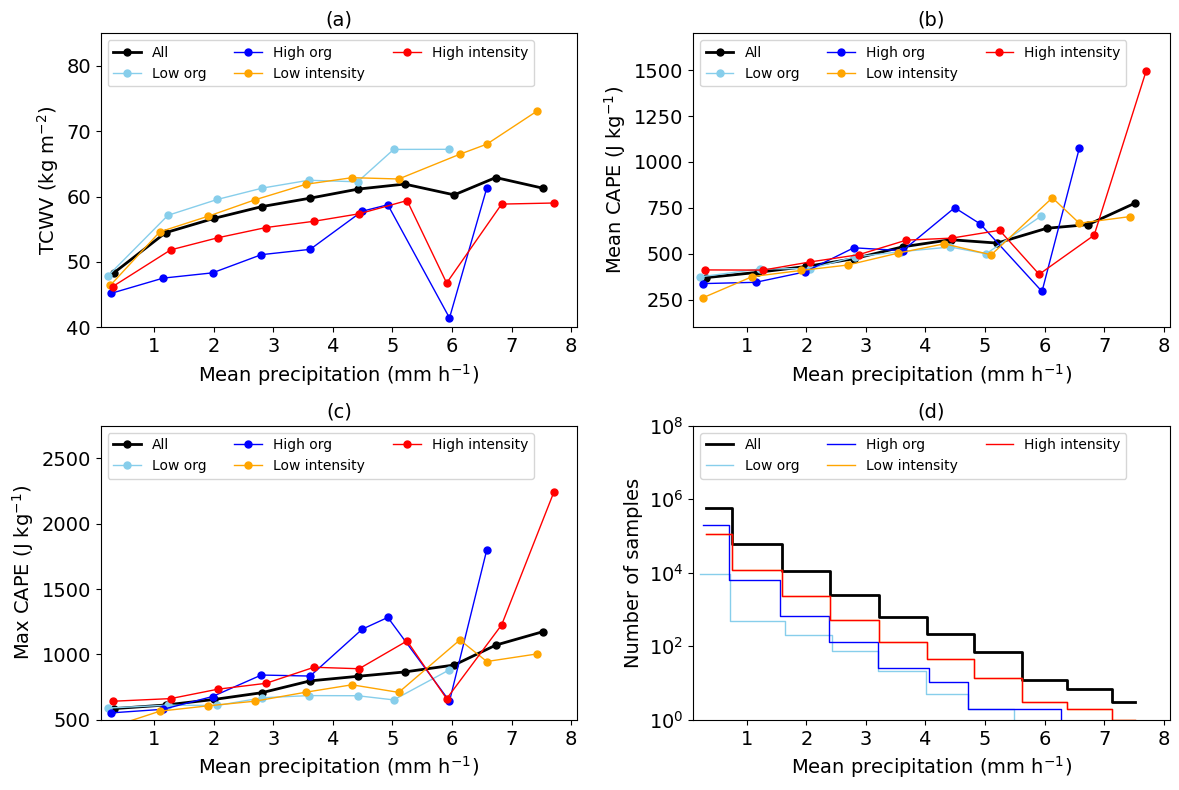

In [12]:

# Create figure and axes
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(221)
# Plot scatter and binned mean
# ax1.scatter(x, y, alpha=0.2, label='Raw data')
ax1.plot(tcwv_result["mean_x_all"], tcwv_result["mean_y_all"],
         marker='o', markersize=5, label="All", color='black')

ax1.plot(tcwv_iorg_result["mean_x_low"], tcwv_iorg_result["mean_y_low"], color='skyblue',
         marker='o', markersize=5,linewidth=1,label='Low org')
ax1.plot(tcwv_iorg_result["mean_x_high"], tcwv_iorg_result["mean_y_high"], color='blue',
         marker='o', markersize=5,linewidth=1,label='High org')

ax1.plot(tcwv_result["mean_x_low"], tcwv_result["mean_y_low"], linewidth=1,
         marker='o', markersize=5,label="Low intensity", color='orange')
ax1.plot(tcwv_result["mean_x_high"], tcwv_result["mean_y_high"],linewidth=1,
         marker='o', markersize=5,label="High intensity", color='red')

ax1.set_xlabel('Mean precipitation (mm h$^{-1}$)')
ax1.set_ylabel('TCWV (kg m$^{-2}$)')
ax1.legend(loc='upper left')
ax1.set_xlim([0.1, 8.1])
ax1.set_ylim([40,85])
lines, labels = ax1.get_legend_handles_labels()

ax1.legend(lines , labels , loc='upper left',ncol=3)
ax1.set_title("(a)")
# Add second y-axis for bin counts
ax2= fig.add_subplot(222)

ax2.plot(mean_cape_result["mean_x_all"], mean_cape_result["mean_y_all"],
         marker='o', markersize=5, label="All", color='black')


ax2.plot(mean_cape_iorg_result["mean_x_low"], mean_cape_iorg_result["mean_y_low"], color='skyblue',
         marker='o', markersize=5,linewidth=1,label='Low org')
ax2.plot(mean_cape_iorg_result["mean_x_high"], mean_cape_iorg_result["mean_y_high"], color='blue',
         marker='o', markersize=5,linewidth=1,label='High org')

ax2.plot(mean_cape_result["mean_x_low"], mean_cape_result["mean_y_low"], linewidth=1,
         marker='o', markersize=5,label="Low intensity", color='orange')
ax2.plot(mean_cape_result["mean_x_high"], mean_cape_result["mean_y_high"],linewidth=1,
         marker='o', markersize=5,label="High intensity", color='red')

ax2.set_xlabel('Mean precipitation (mm h$^{-1}$)')
ax2.set_ylabel('Mean CAPE (J kg$^{-1}$)')
ax2.legend(loc='upper left')
ax2.set_xlim([0.1, 8.1])
ax2.set_ylim([100,1700])
ax2.set_title("(b)")

lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines2, labels2, loc='upper left',ncol=3)




ax3= fig.add_subplot(223)
# Plot scatter and binned mean

ax3.plot(max_cape_result["mean_x_all"], max_cape_result["mean_y_all"],
         marker='o', markersize=5, label="All", color='black')


ax3.plot(max_cape_iorg_result["mean_x_low"], max_cape_iorg_result["mean_y_low"], color='skyblue',
         marker='o', markersize=5,linewidth=1,label='Low org')
ax3.plot(max_cape_iorg_result["mean_x_high"], max_cape_iorg_result["mean_y_high"], color='blue',
         marker='o', markersize=5,linewidth=1,label='High org')

ax3.plot(max_cape_result["mean_x_low"], max_cape_result["mean_y_low"], linewidth=1,
         marker='o', markersize=5,label="Low intensity", color='orange')
ax3.plot(max_cape_result["mean_x_high"], max_cape_result["mean_y_high"],linewidth=1,
         marker='o', markersize=5,label="High intensity", color='red')

ax3.set_xlabel('Mean precipitation (mm h$^{-1}$)')
ax3.set_ylabel('Max CAPE (J kg$^{-1}$)')
ax3.legend(loc='upper left')
ax3.set_xlim([0.1, 8.1])
ax3.set_ylim([500,2750])
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.set_title("(c)")

ax3.legend(lines3 , labels3 , loc='upper left',ncol=3)
# Add second y-axis for bin counts
ax4= fig.add_subplot(224)

ax4.step(tcwv_result["mean_x_all"], tcwv_result["count_all"], where='mid', color='k', linewidth=2, label='All')
ax4.step(tcwv_iorg_result["mean_x_low"], tcwv_iorg_result["count_low"], where='mid', color='skyblue', linewidth=1, label='Low org')
ax4.step(tcwv_iorg_result["mean_x_high"], tcwv_iorg_result["count_high"], where='mid', color='blue', linewidth=1, label='High org')

ax4.step(tcwv_result["mean_x_all"], tcwv_result["count_low"], where='mid', color='orange', linewidth=1, label='Low intensity')
ax4.step(tcwv_result["mean_x_all"], tcwv_result["count_high"], where='mid', color='red', linewidth=1, label='High intensity')
ax4.set_xlabel('Mean precipitation (mm h$^{-1}$)')
ax4.set_ylabel('Number of samples')
ax4.set_yscale('log')
ax4.set_xlim([0.1, 8.1])
# Optional: add legend for second axis
lines4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(lines4 , labels4 , loc='upper left',ncol=3)

ax4.set_title("(d)")

ax4.set_ylim([1,10**8])


plt.tight_layout()
plt.savefig("/home/565/dl6968/meso-org/Figures/Fig2.png", dpi=200, bbox_inches="tight")
plt.show()
